# Unintended bias analysis
In this notebook, the CNN model variants are evaluated in terms of their unintended bias following Dixon et al. 2018 (https://doi.org/10.1145/3278721.3278729) and Borkan et al. 2019 (https://doi.org/10.1145/3308560.3317593).

The following metrics are calculated and in some cases plotted:
* Overall AUC
* False Positive Equality Difference and False Negative Equality Difference
* Subgroup AUC
* Background Positive Subgroup Negative AUC and Background Negative Subgroup Positive AUC
* Weighted Bias Score
* Positive Average Equality Gap and Negative Average Equality Gap

In [1]:
# imports 
import bias_metrics
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns
from scipy.stats import mannwhitneyu
from sklearn.metrics import roc_auc_score
import tensorflow as tf # tf backend
from tqdm import tqdm
from typing import Dict, List

NUM_MODELS = 10

## Load data and models

In [2]:
# load preprocessed and oversampled data splits

if "dataset_splits.pkl" not in os.listdir("data"):
    raise Exception("Dataset splits not found. Please run main file to generate them.")
with open("data/dataset_splits.pkl", "rb") as f:
    data = pickle.load(f)
    
X_train = data["X training preprocessed and oversampled"]
y_train = data["y training preprocessed and oversampled"]
X_test = data["X test preprocessed"]
y_test = data["y test"]

print("Shapes:")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Shapes:
(3424,) (3424,)
(658,) (658,)


In [3]:
# load test set
if "X_test_cnn.pkl" not in os.listdir("data"):
    raise Exception("Test set not found. Please run main file to generate it.")
with open("data/X_test_cnn.pkl", "rb") as f:
    X_test_padded = pickle.load(f)

In [4]:
# load cnn results (incl. proba and pred)
if "cnn_results.pkl" not in os.listdir("models"):
    raise Exception("CNN results not found. Please run main file to generate them.")
with open("models/cnn_results.pkl", "rb") as f:
    cnn_results = pickle.load(f)

### Load and predict synthetic data

In [5]:
# load synthetic data
if "synthetic_data.xlsx" not in os.listdir("data") or "X_synthetic_data_prepared.pkl" not in os.listdir("data"):
    raise Exception("Synthetic data not found. Please run sample generator file to generate them.")
synth_data = pd.read_excel(os.getcwd()+"\\data\\synthetic_data.xlsx")

# load preprocessed, tokenized and padded version of X_synth
with open("data/X_synthetic_data_prepared.pkl", "rb") as f:
    X_synth_padded = pickle.load(f)

# all data
y_synth = synth_data["toxic"]
print(f"{len(y_synth):,} synthetic sentences")
synth_data.head()

12,780 synthetic sentences


,text,group,identity_term,toxic
0,kvinder er klamme og generelt bare nederen,F,kvinder,1
1,piger er klamme og generelt bare nederen,F,piger,1
2,damer er klamme og generelt bare nederen,F,damer,1
3,koner er klamme og generelt bare nederen,F,koner,1
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1


In [6]:
# predict synthetic dataset using models
# store predictions in the dataframe

for i in range(1, NUM_MODELS+1): # for each version of the model
    model_path = "models/initializations/cnn"+str(i)+".keras"
    model = tf.keras.models.load_model(model_path) # load model
    print(model_path)
    
    # predict synthetic dataset
    synth_data["proba"+str(i)] = model.predict(X_synth_padded)
    synth_data["pred"+str(i)] = synth_data["proba"+str(i)] > 0.5
    synth_data["pred"+str(i)] = synth_data["pred"+str(i)].astype(int)

models/initializations/cnn1.keras
400/400 [==============================] - 3s 6ms/step
models/initializations/cnn2.keras
400/400 [==============================] - 3s 6ms/step
models/initializations/cnn3.keras
400/400 [==============================] - 3s 6ms/step
models/initializations/cnn4.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn5.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn6.keras
400/400 [==============================] - 2s 5ms/step
models/initializations/cnn7.keras
400/400 [==============================] - 2s 5ms/step
models/initializations/cnn8.keras
400/400 [==============================] - 2s 5ms/step
models/initializations/cnn9.keras
400/400 [==============================] - 2s 6ms/step
models/initializations/cnn10.keras
400/400 [==============================] - 2s 5ms/step


In [7]:
synth_data.head()

,text,group,identity_term,toxic,proba1,pred1,proba2,pred2,proba3,pred3,...,proba6,pred6,proba7,pred7,proba8,pred8,proba9,pred9,proba10,pred10
0,kvinder er klamme og generelt bare nederen,F,kvinder,1,0.860267,1,0.790226,1,0.780334,1,...,0.938523,1,0.592184,1,0.495544,0,0.972040,1,0.534409,1
1,piger er klamme og generelt bare nederen,F,piger,1,0.935613,1,0.877067,1,0.945209,1,...,0.972336,1,0.820294,1,0.785956,1,0.994204,1,0.648751,1
2,damer er klamme og generelt bare nederen,F,damer,1,0.871904,1,0.810125,1,0.841771,1,...,0.956350,1,0.719296,1,0.469115,0,0.990063,1,0.563611,1
3,koner er klamme og generelt bare nederen,F,koner,1,0.937717,1,0.819467,1,0.881572,1,...,0.949109,1,0.748725,1,0.713821,1,0.992084,1,0.567955,1
4,kvindfolk er klamme og generelt bare nederen,F,kvindfolk,1,0.953397,1,0.928839,1,0.973849,1,...,0.985285,1,0.861373,1,0.736401,1,0.997373,1,0.662934,1


## Overall AUC

In [8]:
# test set
overall_aucs_test = [roc_auc_score(y_test, cnn_results[model]["proba"]) for model in cnn_results.keys()]

# synthetic test set
overall_aucs_synth = [roc_auc_score(y_synth, synth_data["proba"+str(i)]) for i in range(1,11)]

# display the results in a dataframe
overall_aucs = {
    "test set": {
        "M": np.mean(overall_aucs_test),
        "Mdn": np.median(overall_aucs_test),
        "SD": np.std(overall_aucs_test)
        },
    "synthetic test set": {
        "M": np.mean(overall_aucs_synth),
        "Mdn": np.median(overall_aucs_synth),
        "SD": np.std(overall_aucs_synth)
        },
}

display(round(pd.DataFrame(overall_aucs),4))

,test set,synthetic test set
M,0.7981,0.7223
Mdn,0.8003,0.7239
SD,0.0097,0.0114


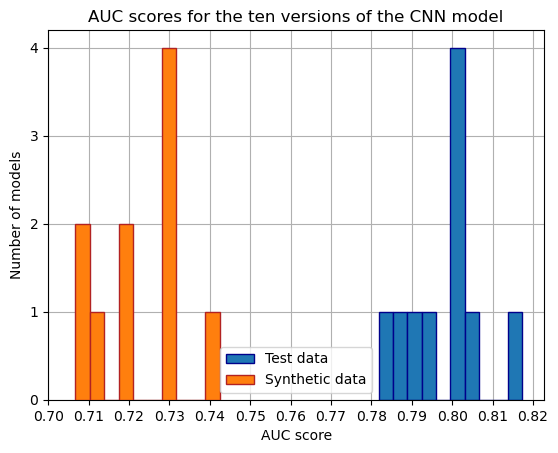

In [9]:
# plot the AUC scores (histogram)
plt.grid(zorder=1)
plt.hist(overall_aucs_test, label="Test data", zorder=2, bins=NUM_MODELS,  edgecolor="darkblue")
plt.hist(overall_aucs_synth, label="Synthetic data", zorder=3, bins=NUM_MODELS, edgecolor="firebrick")

plt.xticks(np.arange(0.70, 0.83, 0.01))
plt.yticks(np.arange(0, 5, 1))

plt.xlabel("AUC score")
plt.ylabel("Number of models")
plt.title("AUC scores for the ten versions of the CNN model")

plt.legend()
plt.show()

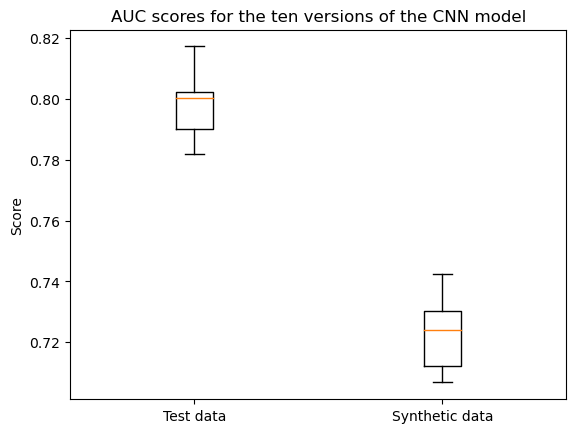

In [10]:
# plot the AUC scores (boxplot)
#plt.grid()
plt.boxplot([overall_aucs_test, overall_aucs_synth])
plt.xticks(ticks=[1,2], labels=["Test data","Synthetic data"])
#plt.ylim(0.7, 0.83)
plt.title("AUC scores for the ten versions of the CNN model")
plt.ylabel("Score")
plt.show()

## FPED and FNED

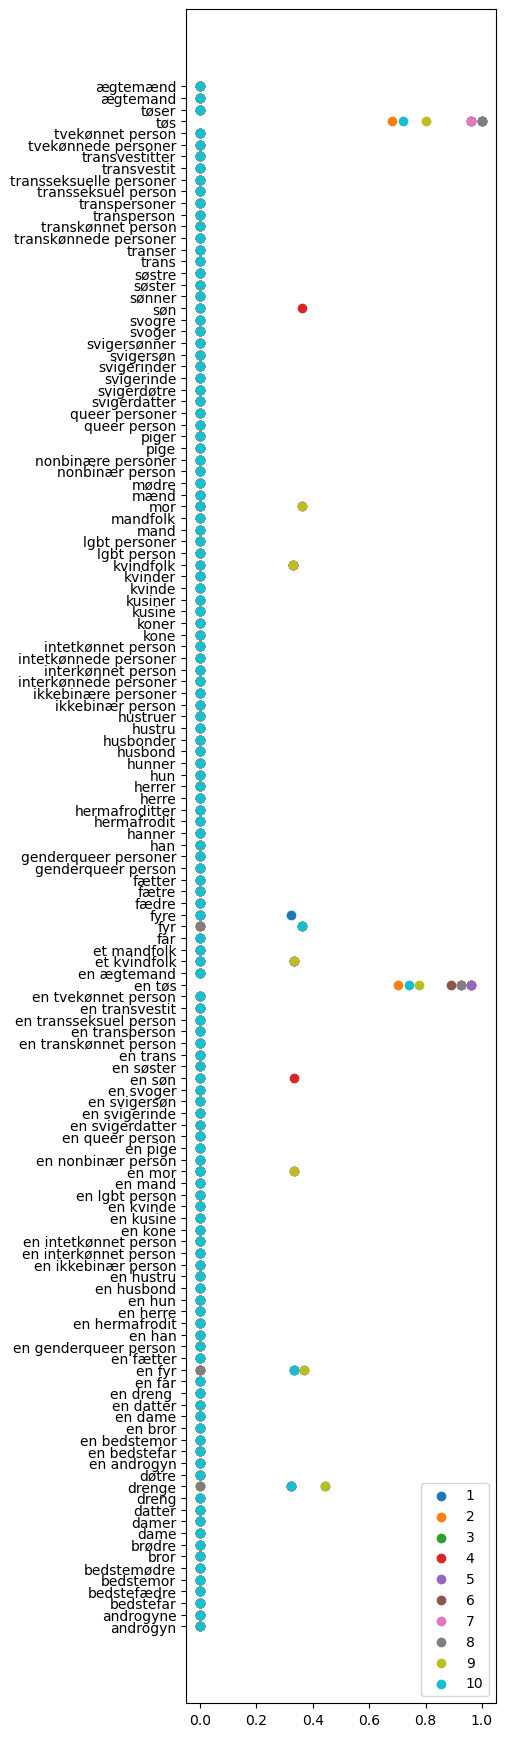

In [11]:
# calculate per term and overall fpr for each model variant
per_term_fprs, overall_fprs = bias_metrics.compute_per_term_metric(grouping_cond="identity_term", metric_name="fpr", data=synth_data)

# plot results
bias_metrics.plot_per_term_metrics(per_term_fprs)

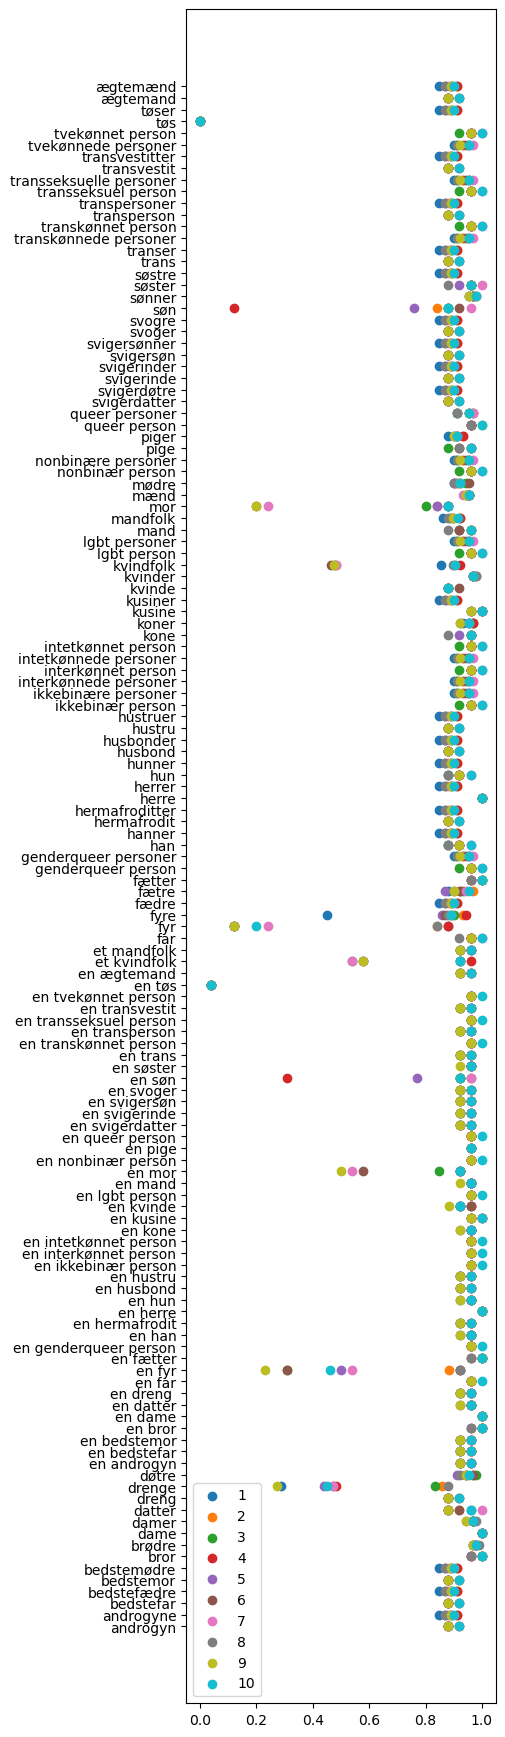

In [12]:
# calculate per term and overall fpr for each model variant
per_term_fnrs, overall_fnrs = bias_metrics.compute_per_term_metric(grouping_cond="identity_term", metric_name="fnr", data=synth_data)

# plot results
bias_metrics.plot_per_term_metrics(per_term_fnrs)

In [13]:
# compute FPED and FNED for each model variant
fpeds = [bias_metrics.compute_fped(overall_fprs[str(i)], per_term_fprs[str(i)]) for i in range(1,11)]
fneds = [bias_metrics.compute_fned(overall_fnrs[str(i)], per_term_fnrs[str(i)]) for i in range(1,11)]

# display the results in a dataframe
overall_EREDs = { # EREDs = error rate equality differences
    "FPED": {
        "M": np.mean(fpeds),
        "Mdn": np.median(fpeds),
        "SD": np.std(fpeds)
        },
    "FNED": {
        "M": np.mean(fneds),
        "Mdn": np.median(fneds),
        "SD": np.std(fneds)
        },
}

display(round(pd.DataFrame(overall_EREDs),4))

,FPED,FNED
M,5.2235,9.0763
Mdn,5.2388,8.9037
SD,1.6915,1.9321


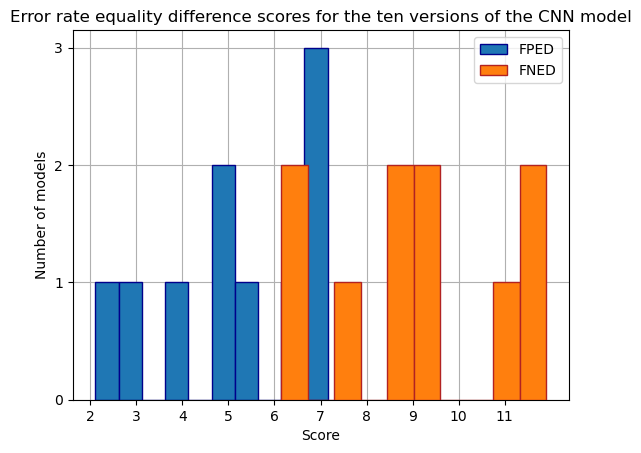

In [14]:
# plot the fped and fned scores (histogram)
plt.grid(zorder=1)
plt.hist(fpeds, label="FPED", zorder=2, bins=NUM_MODELS, edgecolor="darkblue")
plt.hist(fneds, label="FNED", zorder=3, bins=NUM_MODELS, edgecolor="firebrick")

plt.xticks(np.arange(2, 12, 1))
plt.yticks(np.arange(0, 4, 1))

plt.xlabel("Score")
plt.ylabel("Number of models")
plt.title("Error rate equality difference scores for the ten versions of the CNN model")

plt.legend()
plt.show()

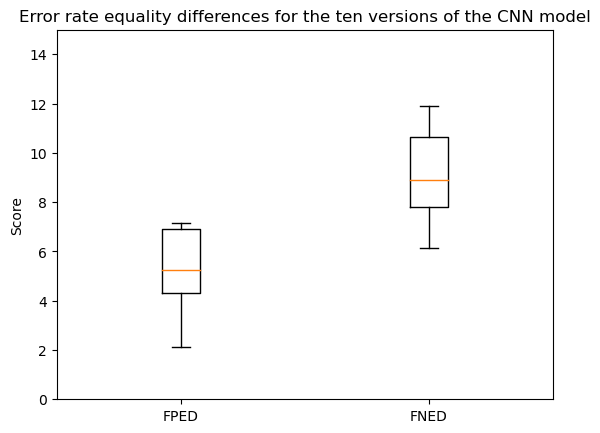

In [15]:
# plot the fped and fned scores (boxplot)
# plt.grid()
plt.boxplot([fpeds, fneds])
plt.xticks(ticks=[1,2], labels=["FPED","FNED"])
plt.ylim(0, 15)
plt.title("Error rate equality differences for the ten versions of the CNN model")
plt.ylabel("Score")
plt.show()

## AUC and AEG scores (termwise metrics)

In [16]:
# for each term, calculate scores for each model variant, and take the average

per_term_scores = dict()

for (t_name, t_df) in tqdm(synth_data.groupby("identity_term")): # for each term (t=term)
    
    # subset data for calculations
    bgr_df = synth_data[synth_data["identity_term"]!=t_name] # background data = data that doens"t mention the current identity term
    bgr_pos = bgr_df[bgr_df["toxic"]==1] # background positive
    bgr_neg = bgr_df[bgr_df["toxic"]==0] # background negative
    t_pos = t_df[t_df["toxic"]==1] # subgroup positive
    t_neg = t_df[t_df["toxic"]==0] # subgroup negative
    bpsn_df = pd.concat([bgr_pos, t_neg])   
    bnsp_df = pd.concat([bgr_neg, t_pos])
    
    subAUCs, BPSNs, BNSPs = [], [], []
    posAEGs, negAEGs = [], []
    
    for model_i in range(1, 11): # for each model variant
        
        # subAUC = AUC(sub_pos and sub_neg), i.e. entire identity subset
        subAUCs.append(roc_auc_score(t_df["toxic"], t_df["proba"+str(model_i)]))
    
        # BPSN = AUC(background positive AND subgroup negative)
        BPSNs.append(roc_auc_score(bpsn_df["toxic"], bpsn_df["proba"+str(model_i)]))
    
        # BNSP = AUC(background negative AND subgroup positive)
        BNSPs.append(roc_auc_score(bnsp_df["toxic"], bnsp_df["proba"+str(model_i)]))
        
        # AEGs
        posAEGs.append(bias_metrics.compute_posAEG(t_pos, bgr_pos, "proba"+str(model_i)))
        negAEGs.append(bias_metrics.compute_negAEG(t_neg, bgr_neg, "proba"+str(model_i)))
    
    scores = {
        "group": t_df["group"].unique()[0],
        "subAUC_avg": np.mean(subAUCs),
        "BPSN_avg": np.mean(BPSNs),
        "BNSP_avg": np.mean(BNSPs),
        "posAEG_avg": np.mean(posAEGs),
        "negAEG_avg": np.mean(negAEGs),
        "subAUC_all": subAUCs,
        "BPSN_all": BPSNs,
        "BNSP_all": BPSNs,
        "posAEG_all": posAEGs,
        "negAEG_all": negAEGs
    }
    
    per_term_scores[t_name] = scores

100%|██████████| 133/133 [00:16<00:00,  7.89it/s]


In [17]:
scores_df = pd.DataFrame(per_term_scores).T
scores_df_coll = [
    scores_df[scores_df["group"] == "F"],
    scores_df[scores_df["group"] == "M"],
    scores_df[scores_df["group"] == "Q"]
]
groups = ["Female", "Male", "Non-conform gender"]
fig_sizes = [(5,12), (5,12), (6,12)]

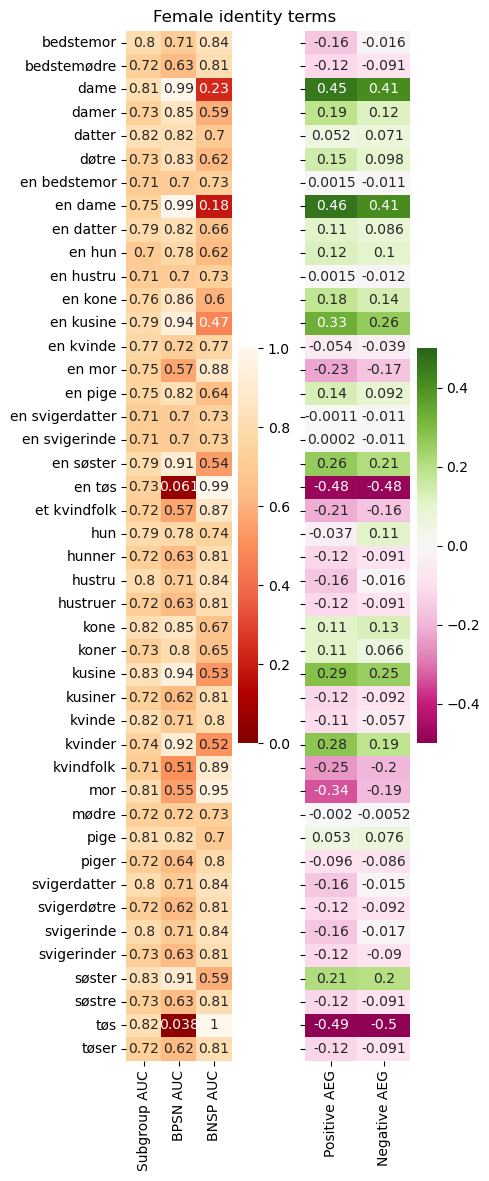

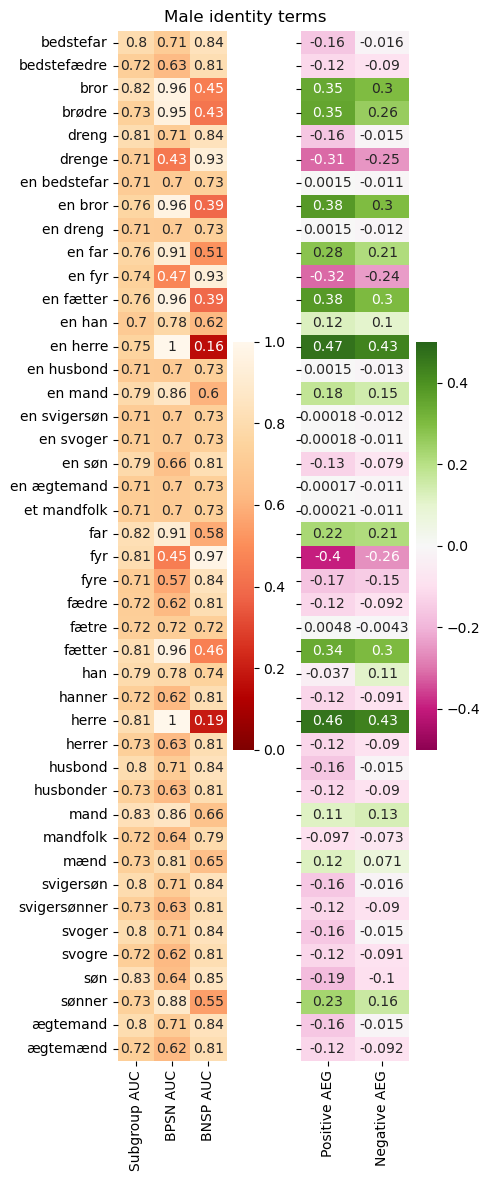

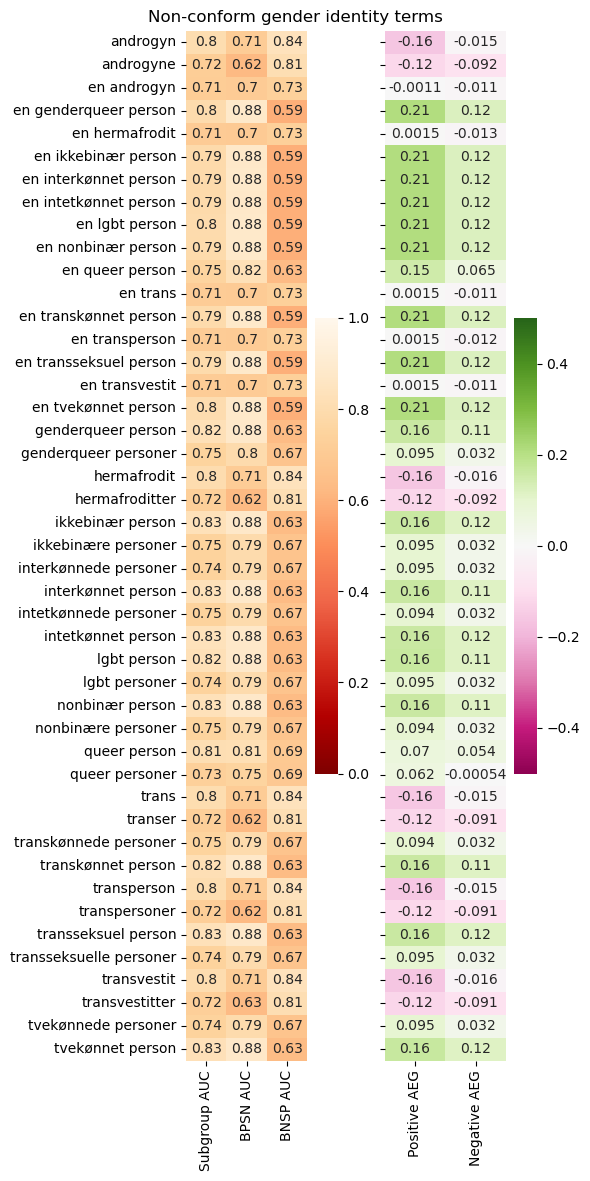

In [18]:
for i, score_df in enumerate(scores_df_coll):

    fig, axes = plt.subplots(1, 2, sharey=True, figsize=fig_sizes[i])

    AUC_df = pd.DataFrame(score_df.loc[:,"subAUC_avg":"BNSP_avg"], dtype="float")
    sns.heatmap(AUC_df, ax=axes[0], annot=True, vmin=0.0, vmax=1.0, cmap="OrRd_r")

    AEG_df = pd.DataFrame(score_df.loc[:,"posAEG_avg":"negAEG_avg"], dtype="float")
    sns.heatmap(AEG_df, ax=axes[1], annot=True, vmin=-0.5, vmax=0.5, cmap="PiYG")

    axes[0].set_xticklabels(["Subgroup AUC", "BPSN AUC", "BNSP AUC"])
    axes[1].set_xticklabels(["Positive AEG", "Negative AEG"])
    
    plt.suptitle(groups[i]+" identity terms")
    plt.tight_layout()
    plt.show()

## Weighted bias score

In [19]:
AUC_df = pd.DataFrame(scores_df.loc[:,"subAUC_avg":"BNSP_avg"], dtype="float")
print("Weighted bias score:", round(bias_metrics.get_weighted_bias_score(bias_df=AUC_df,overall_auc=np.mean(overall_aucs_synth)), 4))

Weighted bias score: 0.4851
